## The Data API

### Creating Dataset

In [4]:
import tensorflow as tf

X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [5]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### Chaining Transformation

In [6]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [7]:
dataset = dataset.map(lambda x: x*2)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [8]:
dataset = dataset.apply(tf.data.experimental.unbatch())

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


In [9]:
for item in dataset.take(5):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


### Shuffling the Data

In [10]:
tf.random.set_seed(42)
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 6 5 7 3 9], shape=(7,), dtype=int64)
tf.Tensor([8 2 1 0 4 6 4], shape=(7,), dtype=int64)
tf.Tensor([7 2 5 9 2 1 3], shape=(7,), dtype=int64)
tf.Tensor([4 3 8 7 9 5 0], shape=(7,), dtype=int64)
tf.Tensor([8 6], shape=(2,), dtype=int64)


In [14]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), 
                                                    random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_mean, X_std = scaler.mean_, scaler.scale_

In [13]:
import os
import numpy as np

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")
    
    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [14]:
train_data = np.c_[X_train, y_train]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header=header, n_parts=20)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header=header, n_parts=10)

In [16]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,4.2143,37.0,5.288235,0.973529,860.0,2.529412,33.81,-118.12,2.285
1,5.3468,42.0,6.364322,1.087940,957.0,2.404523,37.16,-121.98,2.799
2,3.9191,36.0,6.110063,1.059748,711.0,2.235849,38.45,-122.69,1.830
3,6.3703,32.0,6.000000,0.990196,1159.0,2.272549,34.16,-118.41,4.658
4,2.3684,17.0,4.795858,1.035503,706.0,2.088757,38.57,-121.33,1.500


In [19]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
4.2143,37.0,5.288235294117647,0.9735294117647059,860.0,2.5294117647058822,33.81,-118.12,2.285
5.3468,42.0,6.364321608040201,1.0879396984924623,957.0,2.4045226130653266,37.16,-121.98,2.799
3.9191,36.0,6.110062893081761,1.059748427672956,711.0,2.2358490566037736,38.45,-122.69,1.83
6.3703,32.0,6.0,0.9901960784313726,1159.0,2.272549019607843,34.16,-118.41,4.658


### Building an Input Pipeline

In [21]:
import tensorflow as tf
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [22]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', sh

In [23]:
n_reader = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), 
    cycle_length=n_reader
)

In [24]:
for line in dataset.take(5):
    print(line.numpy())

b'3.3125,11.0,5.361736334405145,1.0578778135048232,1963.0,3.1559485530546625,38.69,-121.46,0.968'
b'2.4524,41.0,5.340116279069767,1.188953488372093,1430.0,4.156976744186046,34.13,-117.32,0.704'
b'5.8735,35.0,5.811638591117918,1.0566615620214395,1521.0,2.329249617151608,34.11,-118.63,4.481'
b'3.8788,20.0,5.140068886337543,1.060849598163031,2656.0,3.049368541905855,37.13,-121.66,2.269'
b'4.5893,39.0,5.711688311688311,1.0077922077922077,1025.0,2.6623376623376624,37.95,-122.07,1.9'


### Processing the Data

In [25]:
n_inputs = 8

def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean)/X_std, y

In [26]:
preprocess(b'4.2143,37.0,5.288235294117647,0.9735294117647059,860.0,2.5294117647058822,33.81,-118.12,2.285')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.17648865,  0.66640687, -0.06085434, -0.2811182 , -0.49654418,
        -0.04828325, -0.86074144,  0.73099613], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.285], dtype=float32)>)

In [32]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5, 
                       n_read_threads=None, shuffle_buffer_size=10000, 
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset = dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), 
                                 cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return dataset.batch(batch_size).prefetch(1)

In [30]:
X_train[0]

array([   4.2143    ,   37.        ,    5.28823529,    0.97352941,
        860.        ,    2.52941176,   33.81      , -118.12      ])

### Using Dataset with tf.keras

In [33]:
train_set = csv_reader_dataset(train_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [78]:
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks
model = keras.Sequential([keras.layers.Dense(100, activation="relu"), 
                          keras.layers.BatchNormalization(), 
                          keras.layers.Dense(200, activation="relu"), 
                          keras.layers.BatchNormalization(), 
                          keras.layers.Dense(10, activation="relu"), 
                          keras.layers.BatchNormalization(), 
                          keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=optimizers.SGD(learning_rate=1e-2, nesterov=True, 
                                                   momentum=0.93), metrics=["mae"])
model.fit(train_set, epochs=100, 
          validation_data=test_set, 
          callbacks=[callbacks.EarlyStopping(patience=10, 
                                             restore_best_weights=True, 
                                             monitor="val_loss")])

Epoch 1/100
484/484 [==============================] - 2s 2ms/step - loss: 0.5514 - mae: 0.5358 - val_loss: 0.5612 - val_mae: 0.5202
Epoch 2/100
484/484 [==============================] - 1s 1ms/step - loss: 0.4150 - mae: 0.4621 - val_loss: 0.3551 - val_mae: 0.4313
Epoch 3/100
484/484 [==============================] - 1s 1ms/step - loss: 0.3963 - mae: 0.4492 - val_loss: 0.4187 - val_mae: 0.4794
Epoch 4/100
484/484 [==============================] - 1s 1ms/step - loss: 0.3832 - mae: 0.4426 - val_loss: 0.5200 - val_mae: 0.4968
Epoch 5/100
484/484 [==============================] - 1s 1ms/step - loss: 0.3792 - mae: 0.4359 - val_loss: 0.4806 - val_mae: 0.5197
Epoch 6/100
484/484 [==============================] - 1s 2ms/step - loss: 0.3643 - mae: 0.4304 - val_loss: 0.3219 - val_mae: 0.4059
Epoch 7/100
484/484 [==============================] - 1s 1ms/step - loss: 0.3563 - mae: 0.4240 - val_loss: 0.4373 - val_mae: 0.4445
Epoch 8/100
484/484 [==============================] - 1s 1ms/step - 

In [80]:
model.evaluate(test_set)

162/162 [==============================] - 0s 1ms/step - loss: 0.3219 - mae: 0.4059


[0.3218575417995453, 0.4059430658817291]

In [81]:
new_set = test_set.take(3).map(lambda X, y: X)
model.predict(new_set)

array([[2.9361138 ],
       [0.9133055 ],
       [2.434945  ],
       [2.3590877 ],
       [1.2241691 ],
       [2.530606  ],
       [4.6654253 ],
       [2.7495708 ],
       [0.93317914],
       [2.0079727 ],
       [3.4963975 ],
       [2.6451511 ],
       [2.0391731 ],
       [1.194759  ],
       [1.3651963 ],
       [5.110795  ],
       [3.0155265 ],
       [1.4997151 ],
       [2.5836954 ],
       [1.0702391 ],
       [2.1778834 ],
       [1.0713279 ],
       [0.9217081 ],
       [2.8020098 ],
       [1.7460865 ],
       [2.945178  ],
       [1.7114737 ],
       [2.0891716 ],
       [2.305393  ],
       [2.0068982 ],
       [1.7338572 ],
       [2.7331486 ],
       [3.7790947 ],
       [0.9678383 ],
       [2.425568  ],
       [2.6264007 ],
       [1.9635203 ],
       [1.2492391 ],
       [1.0608734 ],
       [2.624142  ],
       [2.179114  ],
       [1.9583938 ],
       [0.8439145 ],
       [1.301668  ],
       [1.7930489 ],
       [1.8987231 ],
       [1.1935368 ],
       [2.214

In [82]:
# Custom function to train model

@tf.function
def train(model, optimizers, loss_fn, n_epochs, **kwargs):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = loss_fn(y_batch, y_pred)
            loss = tf.add_n([main_loss] + model.losses)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    

## The TFRecord Format

### Creating a TFRecord dataset

In [1]:
import tensorflow as tf
from tensorflow import keras

with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And, This is the second Record.")
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And, This is the second Record.', shape=(), dtype=string)


### Compressed TFRecord Files

In [2]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed_data.tfrecord", options) as f:
    f.write("This is First One")
    f.write("And the Another One")
dataset = tf.data.TFRecordDataset(["my_compressed_data.tfrecord"], 
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is First One', shape=(), dtype=string)
tf.Tensor(b'And the Another One', shape=(), dtype=string)


### Protocol Buffer

In [3]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])), 
            "id": Feature(int64_list=Int64List(value=[123])), 
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", 
                                                          b"c@d.com"]))
        }))

In [4]:
with tf.io.TFRecordWriter("my_contact.tfrecord") as f:
    f.write(person_example.SerializeToString())

### Loading and Parsing Examples

In [15]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""), 
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0), 
    "emails": tf.io.VarLenFeature(tf.string),
}

for serialized_example in tf.data.TFRecordDataset(["my_contact.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, 
                                               feature_description)


In [16]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [17]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [18]:
dataset = tf.data.TFRecordDataset(["my_contact.tfrecord"]).batch(10)
for serialized_example in dataset:
    parsed_examples = tf.io.parse_example(serialized_example, 
                                          feature_description)

### Handling Lists of List Using SequenceExample ProtoBuf

In [21]:
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])), 
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])), 
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"], 
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."], 
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8") for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comment_features = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
    context=context, 
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features), 
        "comments": FeatureList(feature=comment_features)
    })
)

In [22]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0), 
    "title": tf.io.VarLenFeature(tf.string), 
    "pub_data": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]), 
}

sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string), 
    "comments": tf.io.VarLenFeature(tf.string), 
}

serialized_sequence_example = sequence_example.SerializeToString()

In [25]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions, 
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

In [26]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x274a6b47af0>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_data': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0], dtype=int64)>}

In [27]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [28]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x274ade08160>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x274ae02c9d0>}

In [29]:
parsed_content

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>

## Preprocessing the Input Features

### Standardization of data

In [3]:
import numpy as np
from tensorflow import keras

means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps = keras.backend.epsilon()
model = keras.Sequential([
    keras.layers.Lambda(lambda inputs: (input - means) / (stds + eps)), 
    keras.layers.Dense(10), 
    keras.layers.Dense(1)
])

In [4]:
class StandardScaler(keras.layers.Layer):
    def adapt(self, data_samples):
        self.means_ = np.mean(data_samples, axis=0, keepdims=True)
        self.std_ = np.std(data_samples, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_)/(self.std_ + keras.backend.epsilon())

In [5]:
std_layer = StandardScaler()
std_layer.adapt(X_train)

In [6]:
model = keras.Sequential()
model.add(std_layer)

### Encoding Categorical Features Using One-Hot Vectors

In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("dataset", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### in github

In [13]:
import tensorflow as tf
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [15]:
age_mean, age_std = X_mean[1], X_std[1]
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean)/age_std
)

In [16]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.]
)

In [19]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [24]:
ocean_prox_vocab = ["<1H OCEAN", "INLAND", "ISLAND", "NEAR BAY", "NEAR OCEAN"]
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab
)

In [25]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

#### book

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [7]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table= tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets=num_oov_buckets)

In [8]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1], dtype=int64)>

In [9]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab)+num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

### Encoding Categorical Features Using Embeddings

In [10]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

In [11]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.76847804, 0.24180698],
       [0.53683543, 0.04629397],
       [0.62679946, 0.00700271],
       [0.723444  , 0.20266068],
       [0.11565375, 0.5128256 ],
       [0.3641951 , 0.01004899],
       [0.14566624, 0.851266  ]], dtype=float32)>

In [12]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1], dtype=int64)>

In [13]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.723444  , 0.20266068],
       [0.3641951 , 0.01004899],
       [0.53683543, 0.04629397],
       [0.53683543, 0.04629397]], dtype=float32)>

In [14]:
embedding = keras.layers.Embedding(input_dim=len(vocab)+num_oov_buckets, 
                                   output_dim=embedding_dim)

In [15]:
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.03529421, -0.03804005],
       [-0.03340534,  0.03543509],
       [-0.03967112, -0.04716682],
       [-0.03967112, -0.04716682]], dtype=float32)>

In [20]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories], outputs=outputs)

### Keras Preprocessing Layers

In [6]:
normalization = layers.Normalization()
discretization = layers.Discretization()
# pipeline = layers.PreprocessingStage([normalization, discretization])

## TF Transform

In [17]:
import tensorflow_transform as tft

def preprocess(inputs):
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age)
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age": standardized_age, 
        "ocean_proximity_id": ocean_proximity_id
    }

## The Tensorflow Dataset (TFDS) Project

In [25]:
import tensorflow_datasets as tfds

dataset = tfds.load(name="mnist")
mnist_train, mnist_test = dataset["train"], dataset["test"]

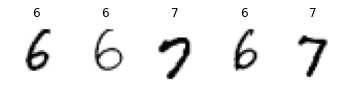

In [26]:
from matplotlib import pyplot as plt
mnist_train = mnist_train.shuffle(10000).batch(32)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break

In [27]:
mnist_train = mnist_train.map(lambda item: (item["image"], item["label"]))
mnist_train = mnist_train.prefetch(1)

In [35]:
## Going all this while loading
dataset = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = dataset["train"].prefetch(1)
mnist_test = dataset["test"].prefetch(1)

In [36]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), 
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"), 
    keras.layers.BatchNormalization(), 
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal"), 
    keras.layers.BatchNormalization(), 
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"), 
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])
model.fit(mnist_train, epochs=10, 
          validation_data=mnist_test, 
          callbacks=[keras.callbacks.EarlyStopping(patience=5, 
                                                   restore_best_weights=True)])

Epoch 1/10
1875/1875 [==============================] - 10s 4ms/step - loss: 0.2149 - accuracy: 0.9339 - val_loss: 0.1012 - val_accuracy: 0.9690
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1003 - accuracy: 0.9688 - val_loss: 0.1040 - val_accuracy: 0.9684
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0722 - accuracy: 0.9770 - val_loss: 0.0965 - val_accuracy: 0.9740
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0516 - accuracy: 0.9826 - val_loss: 0.0978 - val_accuracy: 0.9751
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0415 - accuracy: 0.9863 - val_loss: 0.1245 - val_accuracy: 0.9703
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0341 - accuracy: 0.9886 - val_loss: 0.1383 - val_accuracy: 0.9715
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0293 - accuracy: 0.9898 - val_loss: 0.1127 - val_accuracy

## Exercises

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, initializers, losses, Sequential, datasets
from matplotlib import pyplot as plt
import numpy as np
import random

In [4]:
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

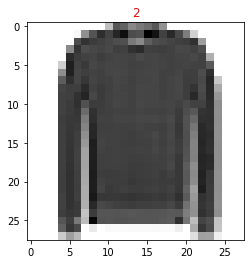

In [23]:
r_in = random.randint(0, 59999)
plt.imshow(X_train[r_in], cmap=plt.cm.binary)
plt.title(y_train[r_in], c="r");

In [25]:
from tensorflow.train import BytesList, Int64List, Feature, Features, Example

In [24]:
for index in range(X_train.shape[0]):
    data = tf.io.encode_jpeg(X_train[index])
    label = y_train[index]
    image_ex = Example(features=Features(feature={
        "image": Feature(bytes_list=BytesList(value=[data.numpy()])), 
        "label": Feature(int64_list=Int64List(value=[label]))
    }))
    with tf.io.TFRecordWriter("my_fashion_mnist.tfrecord") as f:
        f.write(image_ex.SerializeToString())

60000